<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li><li><span><a href="#Модель-LightGBMRegressor" data-toc-modified-id="Модель-LightGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LightGBMRegressor</a></span></li><li><span><a href="#Модель-Ridge" data-toc-modified-id="Модель-Ridge-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель Ridge</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-и-анализ-моделей" data-toc-modified-id="Тестирование-и-анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование и анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, GridSearchCV, TimeSeriesSplit)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345

import warnings
warnings.filterwarnings('ignore')


In [2]:
# выведем данные 
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# смотрим информацию о количестве и типе данных 
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [4]:
print('Количество пропусков:')
display(df.isna().sum())

Количество пропусков:


num_orders    0
dtype: int64

In [5]:
# выполним ресемплирование по одному часу, дню и недели для анализа
df.sort_index(inplace=True)
df_hour = df.resample('1H').sum()
df_day = df.resample('1D').sum()
df_week = df.resample('1W').sum()
df_month = df.resample('1M').sum()

In [6]:
display(df_hour.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

Данные загружены успешно, данные с 1 марта 2018 года по 31 августа 2018 года. Провели ресемплирование по одному часу. Переходим к анализу данных.


## Анализ

In [7]:
# проверим в хронологическом ли порядке расположены даты и время
print(df_hour.index.is_monotonic)

True


In [8]:
# разберём тренды и сезонность
decomposed_hour = seasonal_decompose(df_hour) 
decomposed_day = seasonal_decompose(df_day) 



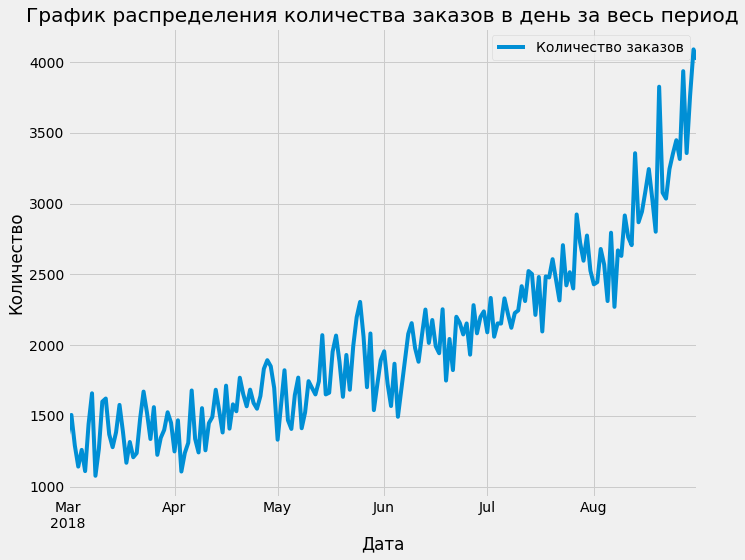

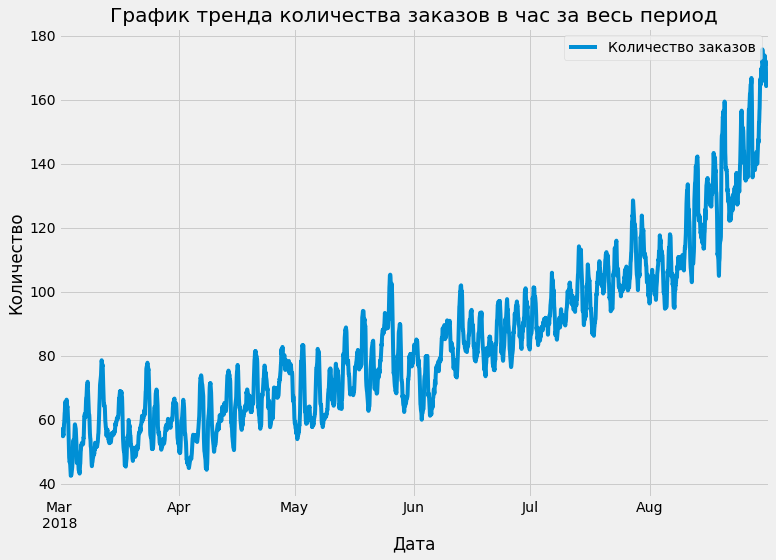

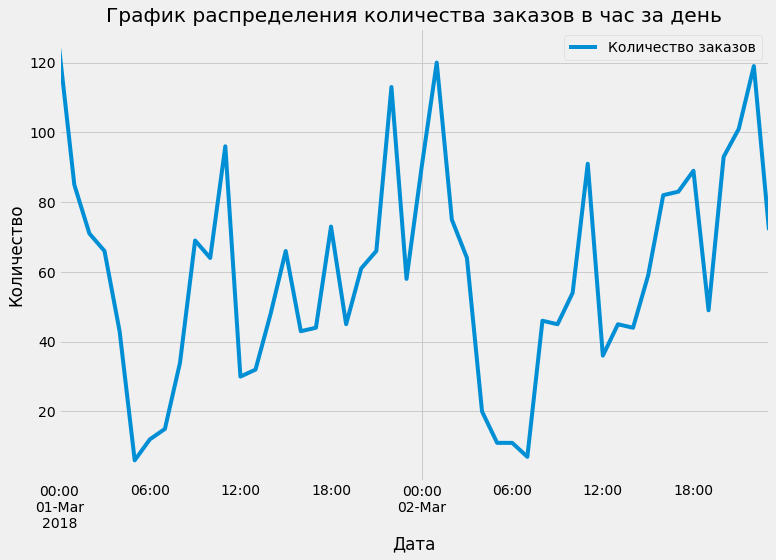

In [9]:
# выведем соответствующие графики для анализа 
plt.style.use("fivethirtyeight")
df_day.plot(subplots=True, figsize=(10, 8))
plt.legend(['Количество заказов'])
plt.title('График распределения количества заказов в день за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

plt.style.use("fivethirtyeight")
decomposed_hour.trend.plot(subplots=True, figsize=(11, 8))
plt.legend(['Количество заказов'])
plt.title('График тренда количества заказов в час за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

plt.style.use("fivethirtyeight")
df_hour['2018-03-01':'2018-03-02'].plot(subplots=True, figsize=(11, 8))
plt.legend(['Количество заказов'])
plt.title('График распределения количества заказов в час за день')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()




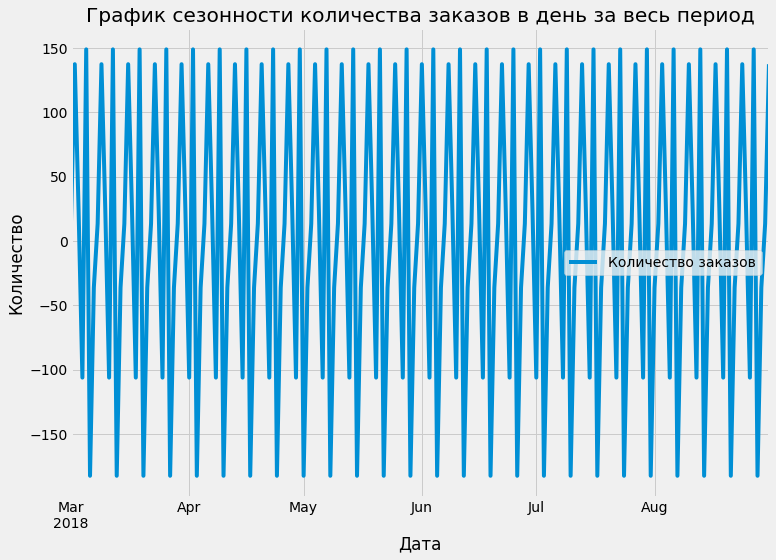

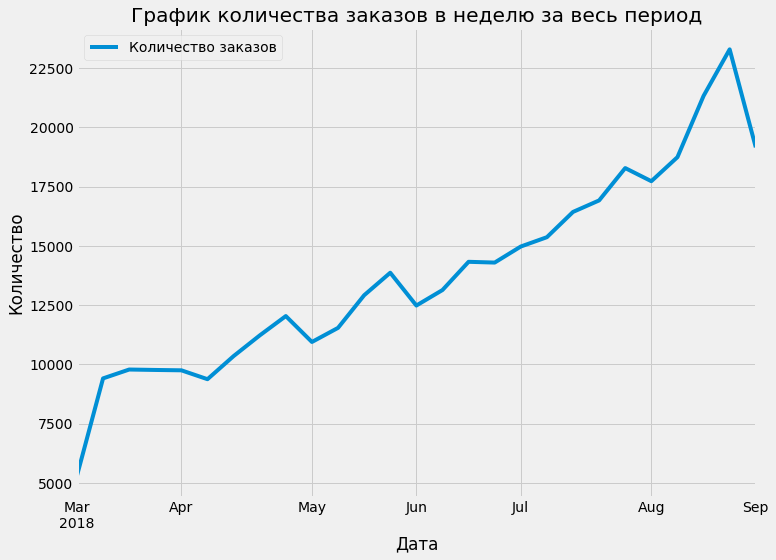

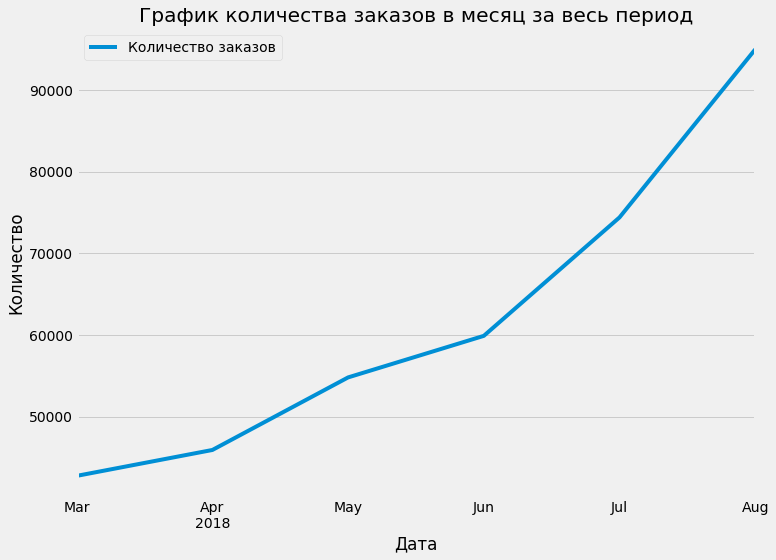

In [10]:
plt.style.use("fivethirtyeight")
decomposed_day.seasonal.plot(subplots=True, figsize=(11, 8))
plt.legend(['Количество заказов'])
plt.title('График сезонности количества заказов в день за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

plt.style.use("fivethirtyeight")
df_week.plot(subplots=True, figsize=(11, 8))
plt.legend(['Количество заказов'])
plt.title('График количества заказов в неделю за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

plt.style.use("fivethirtyeight")
df_month.plot(subplots=True, figsize=(11, 8))
plt.legend(['Количество заказов'])
plt.title('График количества заказов в месяц за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()




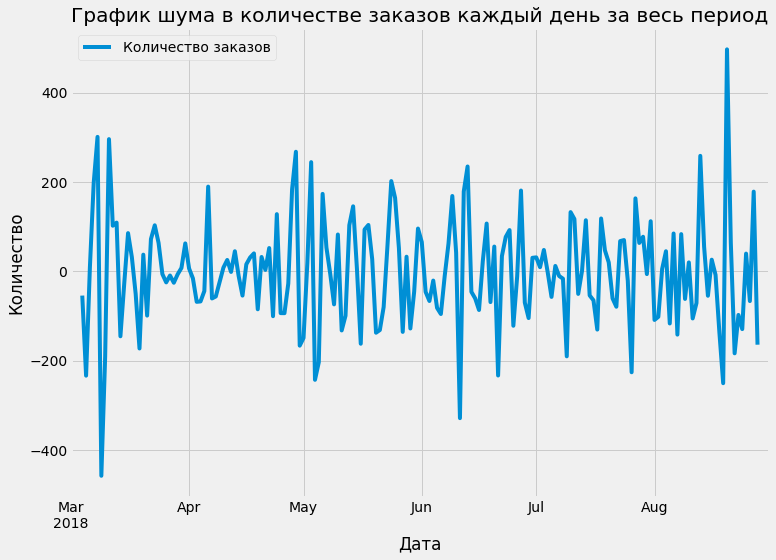

In [11]:
plt.style.use("fivethirtyeight")
decomposed_day.resid.plot(subplots=True, figsize=(11, 8))
plt.legend(['Количество заказов'])
plt.title('График шума в количестве заказов каждый день за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()


Данные расположены в хронологическом порядке. По графикам видно, что тренд количества заказов час к часу и день ко дню растёт. Сезоннность в нашем случае на количество заказов не влиет. По анализу внутри дня наблюдается резкое уменьшение заказов с 1 до 6 утра, что логично. Временной ряд не является стационарным, так как подвержен тренду, который меняется во времени.  Чтобы ряд сделать стационарным, найдём разности его значений. Также найдем скользящее среднее и стандартное отклонение.

In [12]:
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


<AxesSubplot:xlabel='Дата'>

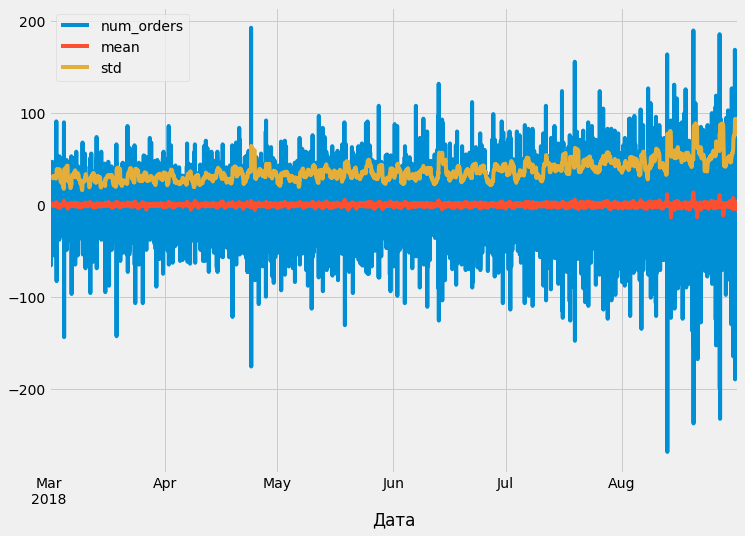

In [13]:
df_hour_shift = df_hour - df_hour.shift()
df_hour_shift['mean'] = df_hour_shift['num_orders'].rolling(24).mean()
df_hour_shift['std'] = df_hour_shift['num_orders'].rolling(24).std()
df_hour_shift.plot(figsize=(11, 8), xlabel='Дата' )

In [14]:
# создадим признаки для обучения модели
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']= data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_hour, 24, 48)

# выделяем 90% данных для обучающей выборки, остальные данные для тестовой
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.shape)
print(test.shape)

(3926, 29)
(442, 29)


In [15]:
# в выборках выделяем целевой признак и признаки:
target_train = train['num_orders']
target_test = test['num_orders']

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3926, 28)
(3926,)
(442, 28)
(442,)


### Вывод

Создали признаки для обучения модели, период не большой, ограничились дневным, недельным и часовым признаком. Поделили выборку на тренировочную и тестовую, выделили целевые признаки. Данные готовы к обучению.

##  Обучение

Будем использовать четыре модели:  RandomForestRegressor, CatBoostRegressor, LGBMRegressor и Ridge.

In [16]:
# для моделей зададим кросс-валидацию TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

###  Модель RandomForestRegressor

In [17]:
# подбираем гиперпарамаметры для модели случайного леса
param = {'max_depth': range(1,21,5),
         'n_estimators':range(1,10,1),
          'min_samples_leaf': range (1,8)}
grid_search_rfr = GridSearchCV(
     RandomForestRegressor(), param, verbose=1, 
    cv=tscv, scoring = 'neg_root_mean_squared_error')



In [18]:
%%time

# инициализируем модель случайного леса
grid_search_rfr.fit(features_train, target_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
CPU times: user 1min 44s, sys: 175 ms, total: 1min 44s
Wall time: 1min 45s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 21, 5),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(1, 10)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [19]:
# выводим модель случайного леса с лучшими гиперпараметрами
grid_search_rfr.best_estimator_


RandomForestRegressor(max_depth=11, min_samples_leaf=4, n_estimators=8)

In [20]:
# RMSE для лучшей модели случайного леса
grid_search_rfr_score = (grid_search_rfr.best_score_*-1).round()
print(grid_search_rfr_score)

26.0


____________

### Модель CatBoostRegressor

In [21]:
# подбираем гиперпарамаметры для модели CatBoostRegressor
param = {'max_depth': range(1,21,10),
         'learning_rate':range(1,2,1)}
grid_search_cbr = GridSearchCV(
     CatBoostRegressor(), param, verbose=1, cv=tscv, scoring = 'neg_root_mean_squared_error')


In [22]:
%%time

# инициализируем модель CatBoostRegressor
grid_search_cbr.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0:	learn: 25.0525436	total: 49.1ms	remaining: 49.1s
1:	learn: 22.4984012	total: 49.6ms	remaining: 24.7s
2:	learn: 21.8184474	total: 50ms	remaining: 16.6s
3:	learn: 21.2424563	total: 50.3ms	remaining: 12.5s
4:	learn: 21.0805262	total: 50.6ms	remaining: 10.1s
5:	learn: 20.7930351	total: 54.5ms	remaining: 9.03s
6:	learn: 20.3590051	total: 54.9ms	remaining: 7.79s
7:	learn: 19.9717837	total: 55.3ms	remaining: 6.86s
8:	learn: 19.7745538	total: 55.8ms	remaining: 6.14s
9:	learn: 19.5698047	total: 56.5ms	remaining: 5.59s
10:	learn: 19.4124491	total: 57.2ms	remaining: 5.14s
11:	learn: 19.2837479	total: 57.5ms	remaining: 4.74s
12:	learn: 19.1210042	total: 57.9ms	remaining: 4.4s
13:	learn: 18.9574214	total: 58.4ms	remaining: 4.11s
14:	learn: 18.7045705	total: 58.8ms	remaining: 3.86s
15:	learn: 18.4656177	total: 59.2ms	remaining: 3.64s
16:	learn: 18.2949603	total: 59.6ms	remaining: 3.45s
17:	learn: 18.1505962	total: 60ms	remaining: 3.27s
1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fac820e2220>,
             param_grid={'learning_rate': range(1, 2),
                         'max_depth': range(1, 21, 10)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [23]:
# выводим модель CatBoostRegressor с лучшими гиперпараметрами
grid_search_cbr.best_params_

{'learning_rate': 1, 'max_depth': 1}

In [24]:
# RMSE для лучшей модели CatBoostRegressor
grid_search_cbr_score = (grid_search_cbr.best_score_*-1).round()
print(grid_search_cbr_score)

29.0


________

### Модель LightGBMRegressor

Выберем параметры попроще, чтобы не тратить много времени на поиск оптимальных параметров.

In [25]:
# подбираем гиперпарамаметры для модели LightGBMRegressor
param = {'num_leaves': range(1,3,1),
         'max_depth': range (1,3,1)}
grid_search_lgr = GridSearchCV(
     LGBMRegressor(), param, verbose=1, cv=tscv, scoring = 'neg_root_mean_squared_error')


In [26]:
%%time

# инициализируем модель LightGBMRegressor
grid_search_lgr.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

CPU times: user 1min 49s, sys: 1.23 s, total: 1min 50s
Wall time: 1min 50s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'max_depth': range(1, 3), 'num_leaves': range(1, 3)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [27]:
# выводим модель LightGBMRegressor с лучшими гиперпараметрами
grid_search_lgr.best_params_

{'max_depth': 1, 'num_leaves': 2}

In [28]:
# RMSE для лучшей модели LightGBMRegressor
grid_search_lgr_score = (grid_search_lgr.best_score_*-1).round()
print(grid_search_lgr_score)

28.0


_______

### Модель Ridge

In [29]:
# подбираем гиперпарамаметры для модели Ridge
param = {'alpha':[1, 10],
        }

grid_search_rid = GridSearchCV(
    Ridge(), param, verbose=1, cv=tscv, scoring = 'neg_root_mean_squared_error')


In [30]:
%%time

# инициализируем модель Ridge
grid_search_rid.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 293 ms, sys: 494 ms, total: 787 ms
Wall time: 747 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(), param_grid={'alpha': [1, 10]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
# выводим модель Ridge с лучшими гиперпараметрами
grid_search_rid.best_params_

{'alpha': 10}

In [32]:
# RMSE для лучшей модели Ridge
grid_search_rid_score = (grid_search_rid.best_score_*-1).round()
print(grid_search_rid_score)

27.0


### Вывод

Обучили 4 модели - RandomForestRegressor, CatBoostRegressor, LGBMRegressor и Ridge со сменой гиперпараметров. Анализ и выбор лучшей модели будет приведен в сводной таблице в следующей главе.

## Тестирование и анализ моделей

In [40]:
# сводная таблица по показателям RMSE, время обучения модели :
index = ['RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'Ridge']

data = {'RMSE':[grid_search_rfr_score,
                grid_search_cbr_score,
                grid_search_lgr_score,
                grid_search_rid_score],
        
        'Время обучения модели':[1.45, 
                              8.45,
                              1.50,
                              0.01],
       }

data = pd.DataFrame(data=data, index=index)

data.sort_values(by = 'RMSE', ascending=True)


,RMSE,Время обучения модели
RandomForestRegressor,26.0,1.45
Ridge,27.0,0.01
LGBMRegressor,28.0,1.50
CatBoostRegressor,29.0,8.45


Лучшей моделью по RMSE является RandomForestRegressor, но по времени обучения Ridge вне конкуренции. 

In [34]:
# тестирование лучшей модели на тестовой выборке 
model_test = RandomForestRegressor(max_depth=11, min_samples_leaf=5, n_estimators=9)
model_test.fit(features_train, target_train)

RandomForestRegressor(max_depth=11, min_samples_leaf=5, n_estimators=9)

In [35]:
predictions = model_test.predict(features_test)

In [36]:
rmse = ((mean_squared_error(target_test, predictions)) ** 0.5).round()

In [37]:
print("RMSE для RandomForestRegressor на тестовой выборке", rmse)

RMSE для RandomForestRegressor на тестовой выборке 46.0


In [38]:
# добавим проверку модели на адекватность
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [39]:
print("RMSE:", (mean_squared_error(target_test, pred_previous)) ** 0.5)



RMSE: 58.856486242815066


## Вывод

В ходе работы было выполнено:

 1. Загрузили данные и выполнили их ресемплирование по одному часу.
 2. Выполнили графический анализ данных.
 3. Обучили и выполнили сравнение 4-х моделей RandomForestRegressor, CatBoostRegressor,   LGBMRegressor и Ridge с использованием различных наборов гиперпараметров.
 4. Выбрана лучшая модель по результатам метрики RMSE и проверена на тестовой выборке.
 
Лучшей моделью можно считать RandomForestRegressor. Остальные модели показали себя хуже. RMSE для модели RandomForestRegressor на тестовой выборке 46, что входит в требуемый диапазон не больше 48. 
